## <center>Predicting players rating

## Import Libraries

In [424]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV, ShuffleSplit, RandomizedSearchCV
import matplotlib.pyplot as plt
import os
import seaborn as sns
import statsmodels.api as statsmodels
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import Imputer, StandardScaler
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from sklearn import metrics
import pickle
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import make_pipeline
pd.set_option('display.max_columns', None)

In [425]:
#Change Working Directory

os.chdir('D:/Data Science/Python/PROJECT-2 PREDICTING PLAYERS RATING')

## Create Connection to Database and Read Data

In [426]:
# Create your connection.
cnx = sqlite3.connect('database.sqlite')

# Read data from Player_Attributes Table into dataframe

df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

## Explore Data

In [427]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [429]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,183978.0,91989.500000,53110.018250,1.0,45995.25,91989.5,137983.75,183978.0
player_fifa_api_id,183978.0,165671.524291,53851.094769,2.0,155798.00,183488.0,199848.00,234141.0
player_api_id,183978.0,135900.617324,136927.840510,2625.0,34763.00,77741.0,191080.00,750584.0
overall_rating,183142.0,68.600015,7.041139,33.0,64.00,69.0,73.00,94.0
potential,183142.0,73.460353,6.592271,39.0,69.00,74.0,78.00,97.0
crossing,183142.0,55.086883,17.242135,1.0,45.00,59.0,68.00,95.0
finishing,183142.0,49.921078,19.038705,1.0,34.00,53.0,65.00,97.0
heading_accuracy,183142.0,57.266023,16.488905,1.0,49.00,60.0,68.00,98.0
short_passing,183142.0,62.429672,14.194068,3.0,57.00,65.0,72.00,97.0
volleys,181265.0,49.468436,18.256618,1.0,35.00,52.0,64.00,93.0


### <b>Observations</b><br>
* We have some Null values invarious columns to consider.
* We may need to create dummy variables for <b>categorical data preferred_foot, attacking_work_rate, defensive_work_rate</b> and check their impacts on the <b>overall_rating</b>
* The variables <b>id, player_fifa_api_id,player_api_id</b> presumably should have no impact on the target variable. So, we may remove them while preparing for model creation


## Data Cleaning

### Treating Null Values

In [430]:
# Find number of null data points in each column

df.isnull().sum(axis=0)

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

### Observations<br>
* We have about 2800 null data points at max in any column. We may drop these datapoints

In [431]:
# Number of rows in initial dataset

rows = df.shape[0]

# Drop the NULL rows
df.dropna(axis = 0, inplace = True)
df.shape

(180354, 42)

In [432]:
# Number of rows removed as a result of dropping null value rows

rows - df.shape[0]

3624

### Treating Numeric features based on corelation

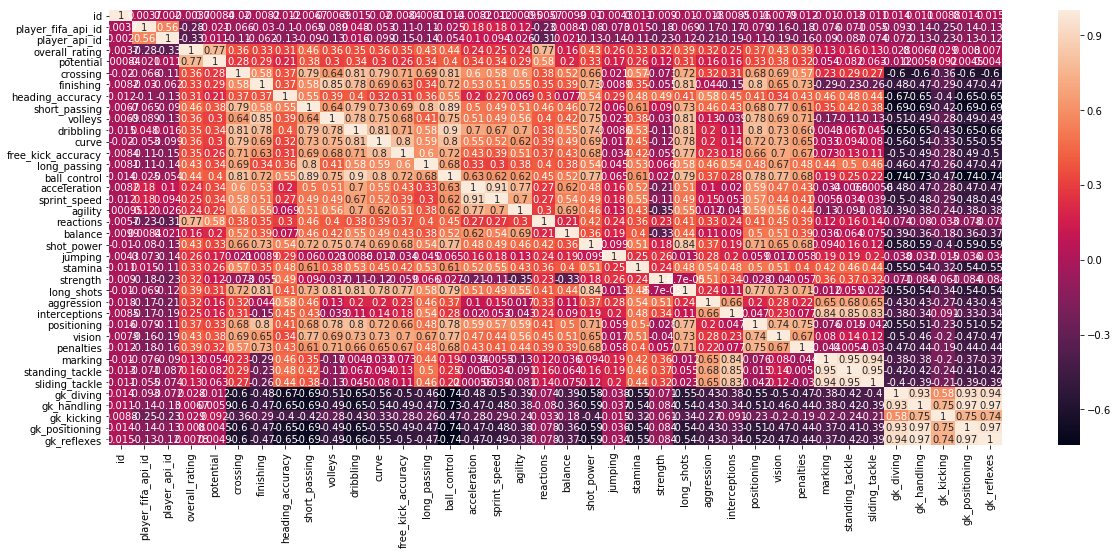

In [433]:
# Getting correlation between various numerical columns
corr=df.corr()
# Checking for correlations using HEATMAP
plt.figure(figsize=(20,8))
sns.heatmap(corr,annot=True)
plt.show()

### Observations:<br>
* All variables are positively corelated with <b>Overall Rating</b> except <b>id, player_fifa_api_id, player_api_id</b>. So these variables can be removed from the Regression Model.
* Also, we need to remove all features with high correlation (>0.75)

In [434]:
# Remove all the columns for which we see high correlation( i.e >0.75)

df_corr = df.corr().abs()
up_tri = df_corr.where(np.triu(np.ones(df_corr.shape[1]),k=1).astype(np.bool))
corr_features = [ column for column in up_tri.columns if any(up_tri[column]> 0.75)]

In [402]:
#Numeric features to be considerd for Independent Variables

print(corr_features)

['potential', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'sprint_speed', 'agility', 'reactions', 'shot_power', 'long_shots', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_handling', 'gk_positioning', 'gk_reflexes']


### Treating Categorical Features

In [445]:
cat_cols = df.select_dtypes(include='object').columns.values

In [447]:
# Checking the number of unique values in the categorical columns

df[cat_cols].nunique()

date                   197
preferred_foot           2
attacking_work_rate      8
defensive_work_rate     18
dtype: int64

### Checking impact of Categorical Columns

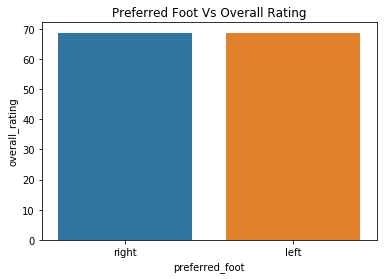

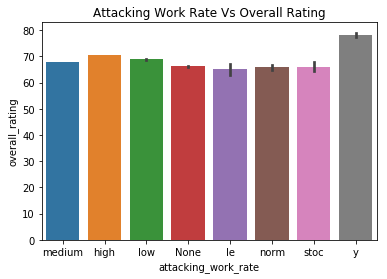

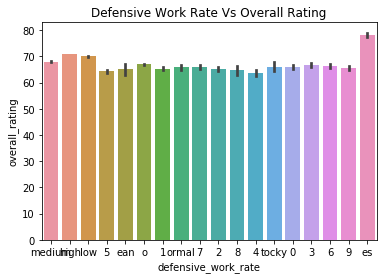

In [448]:
# Impact of Preferred Foot.
sns.barplot(x='preferred_foot', y='overall_rating', data=df, estimator=np.mean)
plt.title('Preferred Foot Vs Overall Rating')
plt.show()

# Impact of Attacking Work Rate.
sns.barplot(x='attacking_work_rate', y='overall_rating', data=df, estimator=np.mean)
plt.title('Attacking Work Rate Vs Overall Rating')
plt.show()

# Impact of Defensive Work Rate.
sns.barplot(x='defensive_work_rate', y='overall_rating', data=df, estimator=np.mean)
plt.title('Defensive Work Rate Vs Overall Rating')
plt.show()

### Observations:<br> 
* Here the Overall Rating is almost same for the different values of <b>preferred_foot, attacking_work_rate, defensive_work_rate</b>. So these variables can be removed from the Estimators, and these have already been ignored as a result of highly correlated features above

In [449]:
features=corr_features

### Define Independent and Target Variables based on observations so far

In [452]:
y=df['overall_rating']
X=df[features]

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

### Feature Selection
* Though we have already prepared the features required, but let us finetune this further with feature selection

In [454]:
#imputing null value of each column with the mean of that column
from sklearn.impute import SimpleImputer
imput = SimpleImputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

#finding feature_importance for feature selection

model = XGBRegressor()
model.fit(X_train, y_train)
model.feature_importances_

array([0.1851575 , 0.0227492 , 0.00657381, 0.00923773, 0.00572469,
       0.        , 0.00431019, 0.13792126, 0.00635552, 0.0060846 ,
       0.23764078, 0.06169679, 0.00952527, 0.02892486, 0.00329863,
       0.02404797, 0.05347796, 0.07938205, 0.00790269, 0.04499975,
       0.03671375, 0.02827498], dtype=float32)

In [455]:
#Selectiong features with importance > 0.1

selection = SelectFromModel(model, threshold=0.01, prefit=True)

select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)
select_X_train.shape

(126247, 12)

## Model Building<br>
We will try various models before concluding on to selecting the best one for prediction

### 1. Linear Regression Model

In [456]:
pipe_lr = make_pipeline(StandardScaler(),             
                     LinearRegression())           

cv_lr = ShuffleSplit(random_state=0)   #shuffle spliting for cross_validation

param_lr = {'linearregression__n_jobs': [-1]}    

grid_lr = GridSearchCV(pipe_lr, param_grid=param_lr, cv=cv_lr)

In [457]:
grid_lr.fit(select_X_train, y_train)     

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'linearregression__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [458]:
grid_lr.best_params_

{'linearregression__n_jobs': -1}

In [459]:
import pickle
lr_reg = pickle.dumps(grid_lr)

### 2. Random Forest:

In [460]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = make_pipeline(StandardScaler(),
                     RandomForestRegressor(n_estimators=10, random_state=12))

cv_rf = ShuffleSplit(test_size=0.2, random_state=0)

param_rf = {'randomforestregressor__max_features':['sqrt', 'log2', 10],
              'randomforestregressor__max_depth':[10, 15, 18]}                 

grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=cv_rf)

In [461]:
grid_rf.fit(select_X_train, y_train)   

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decr...mators=10, n_jobs=None,
           oob_score=False, random_state=12, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'randomforestregressor__max_features': ['sqrt', 'log2', 10], 'randomforestregressor__max_depth': [10, 15, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [462]:
grid_rf.best_params_

{'randomforestregressor__max_depth': 18,
 'randomforestregressor__max_features': 10}

In [463]:
rf_reg = pickle.dumps(grid_rf)

### 3. Decision Tree

In [464]:
pipe_dt = make_pipeline(StandardScaler(),                  
                     DecisionTreeRegressor(criterion='mse', random_state=3))

cv_dt = ShuffleSplit(n_splits=10, random_state=3)        #cross validation

param_dt = {'decisiontreeregressor__max_depth': [5, 7, 9, 13,15,18]}

grid_dt = GridSearchCV(pipe_dt, param_grid=param_dt, cv=cv_dt)

In [465]:
grid_dt.fit(select_X_train, y_train) 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=3, test_size='default',
       train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=3, splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeregressor__max_depth': [5, 7, 9, 13, 15, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [466]:
grid_dt.best_params_

{'decisiontreeregressor__max_depth': 18}

In [467]:
dt_reg = pickle.dumps(grid_dt)

### 4. XGBoost

In [468]:
pipe_xg = make_pipeline(StandardScaler(),
                     XGBRegressor(n_estimators= 10, random_state=5))

cv_xg = ShuffleSplit(n_splits=10, random_state=3)

param_xg = {'xgbregressor__max_depth': [7,9,11],
              'xgbregressor__learning_rate': [0.1, 0.3]}

grid_xg = GridSearchCV(pipe_xg, param_grid=param_xg, cv=cv_xg)

In [469]:
grid_xg.fit(select_X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=3, test_size='default',
       train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_ch... reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'xgbregressor__max_depth': [7, 9, 11], 'xgbregressor__learning_rate': [0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [470]:
grid_xg.best_params_

{'xgbregressor__learning_rate': 0.3, 'xgbregressor__max_depth': 11}

In [471]:
xg_reg = pickle.dumps(grid_xg)

In [472]:
xg = pickle.loads(xg_reg)

## Comparing All The Models Build based on the accuracy

In [473]:
lr = pickle.loads(lr_reg)
rf = pickle.loads(rf_reg)
dt = pickle.loads(dt_reg)
xg = pickle.loads(xg_reg)

In [475]:
lr_score=lr.score(select_X_test, y_test)
rf_score=rf.score(select_X_test, y_test)
dt_score=dt.score(select_X_test, y_test)
xg_score=xg.score(select_X_test, y_test)

In [476]:
print('Linear Regressor accuracy = ',lr_score)
print('RandomForest regressor accuracy = ',rf_score)
print('DecisionTree Regressor accuracy = ',dt_score)
print('XGBoost regressor accuracy = ',xg_score)

Linear Regressor accuracy =  0.7896470969217847
RandomForest regressor accuracy =  0.9626631076390332
DecisionTree Regressor accuracy =  0.9408237563015882
XGBoost regressor accuracy =  0.8592176893520419


## Conclusion<br>
We observe that the Random Forest can predict with an accuracy of 96.27%, based on the prediciton accuracy on the test data set. So, we can use the Random Forest model built for predictions of Player Ratings